## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

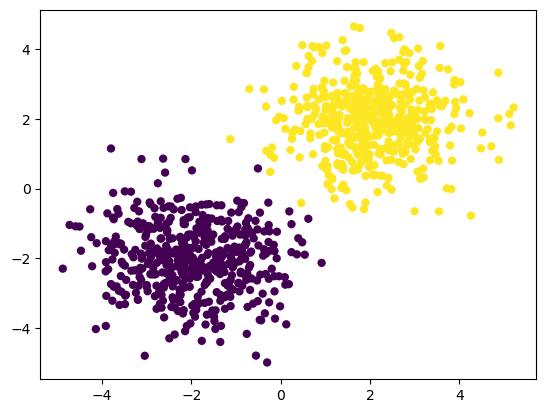

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential() # type: ignore
net.add(Linear(2, 2)) # type: ignore
net.add(LogSoftMax()) # type: ignore

criterion = ClassNLLCriterion() # type: ignore

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

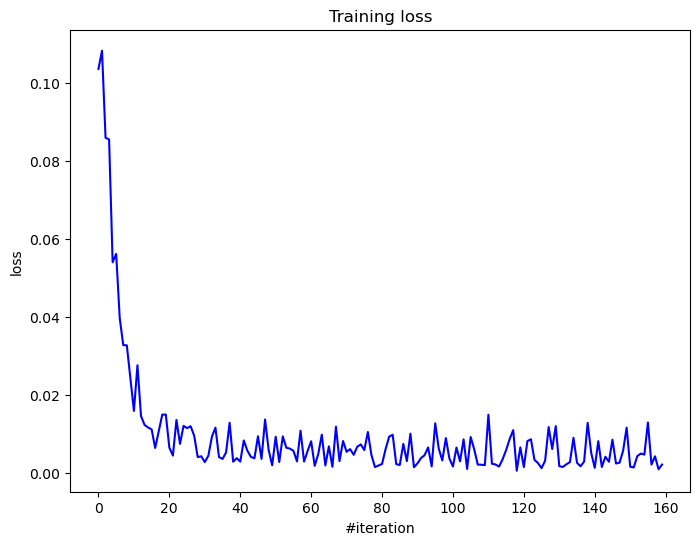

Current loss: 0.002186


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

n_classes = 10
y_train_oh = np.eye(n_classes, dtype=np.float32)[y_train]
y_val_oh   = np.eye(n_classes, dtype=np.float32)[y_val]
y_test_oh  = np.eye(n_classes, dtype=np.float32)[y_test]

print("X_train:", X_train.shape, "y_train:", y_train.shape, "y_train_oh:", y_train_oh.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape,   "y_val_oh  :", y_val_oh.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape,  "y_test_oh :", y_test_oh.shape)


X_train: (50000, 784) y_train: (50000,) y_train_oh: (50000, 10)
X_val  : (10000, 784) y_val  : (10000,) y_val_oh  : (10000, 10)
X_test : (10000, 784) y_test : (10000,) y_test_oh : (10000, 10)


One-hot encode the labels first.

In [9]:
n_classes = 10

y_train_oh = np.eye(n_classes, dtype=np.float32)[y_train]
y_val_oh   = np.eye(n_classes, dtype=np.float32)[y_val]
y_test_oh  = np.eye(n_classes, dtype=np.float32)[y_test]


In [10]:
print(y_train_oh.shape, y_val_oh.shape, y_test_oh.shape)
print(y_train_oh[0], "label =", y_train[0])


(50000, 10) (10000, 10) (10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] label = 5


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

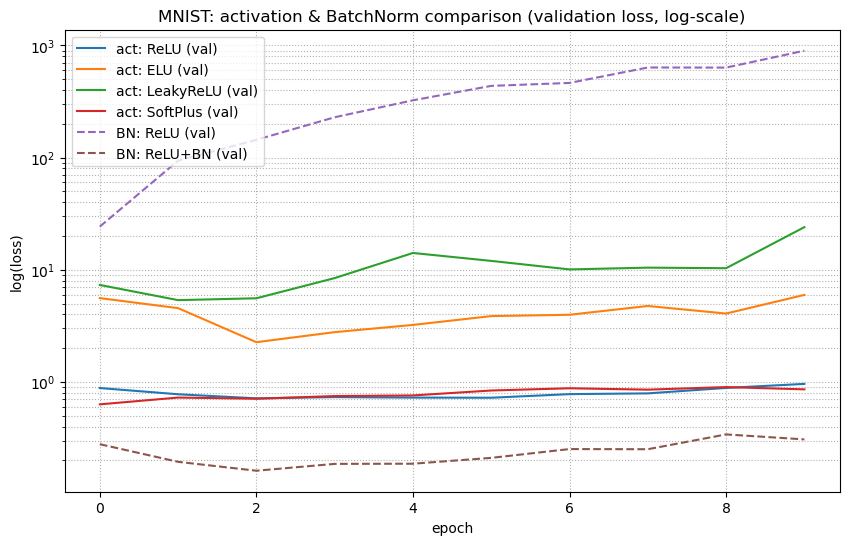

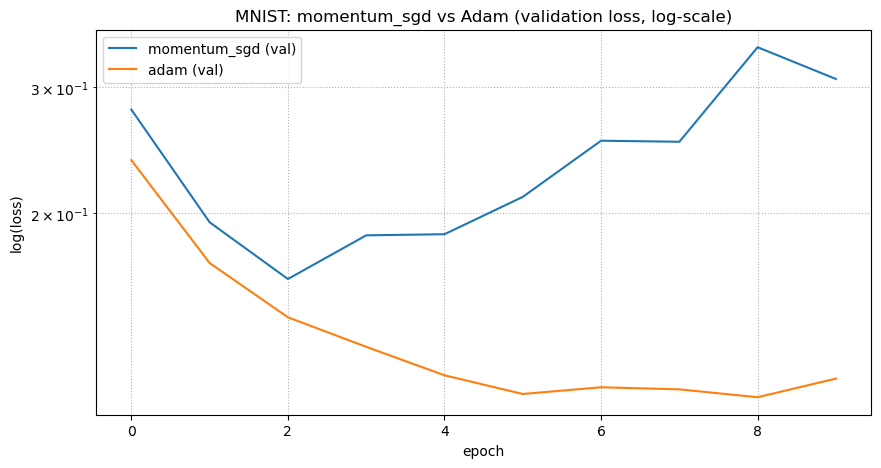

Activation comparison (final val_loss / val_acc):
ReLU      : val_loss=0.9622, val_acc=0.8267
ELU       : val_loss=5.9768, val_acc=0.8645
LeakyReLU : val_loss=23.9920, val_acc=0.8750
SoftPlus  : val_loss=0.8603, val_acc=0.8374

BatchNorm comparison (final val_loss / val_acc):
ReLU      : val_loss=896.1136, val_acc=0.0991
ReLU+BN   : val_loss=0.3081, val_acc=0.9674

Optimizer comparison (final val_loss / val_acc) [ReLU+BN]:
momentum_sgd: val_loss=0.3081, val_acc=0.9674
adam        : val_loss=0.1176, val_acc=0.9732


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def iterate_minibatches(X, y, batch_size=128, shuffle=True, seed=42):
    rng = np.random.default_rng(seed)
    indices = np.arange(len(X))
    if shuffle:
        rng.shuffle(indices)
    for start in range(0, len(X) - batch_size + 1, batch_size):
        batch_idx = indices[start:start+batch_size]
        yield X[batch_idx], y[batch_idx]

def accuracy_from_logits(logits, y_true_int):
    y_pred = np.argmax(logits, axis=1)
    return (y_pred == y_true_int).mean()

def safe_curve(y):
    """Replace non-finite values with NaN so plotting never crashes."""
    y = np.asarray(y, dtype=np.float64)
    y[~np.isfinite(y)] = np.nan
    return y

def get_optimizer(name):
    g = globals()
    aliases = {
        "momentum_sgd": ["momentum_sgd", "sgd_momentum", "MomentumSGD", "SGDMomentum"],
        "adam": ["adam", "Adam", "adam_optimizer", "AdamOptimizer"],
    }
    for a in aliases.get(name.lower(), []):
        if a in g:
            return g[a]
    for k in g.keys():
        if k.lower() == name.lower():
            return g[k]
    raise NameError(f"Optimizer '{name}' not found in globals(). Available keys sample: {list(g.keys())[:30]}")

class OptimizerWrap:
    """
    Wraps functional optimizers from modules.ipynb with signature:
      update_fn(variables, gradients, config, state)
    into an object with .step(model).
    """
    def __init__(self, update_fn, config):
        self.update_fn = update_fn
        self.config = dict(config)
        self.state = {}

    def step(self, model):
        self.update_fn(model.getParameters(), model.getGradParameters(), self.config, self.state)

def train_model(model, criterion, optimizer, X_train, y_train_oh, y_train_int,
                X_val, y_val_oh, y_val_int,
                n_epochs=10, batch_size=128, seed=42, verbose=False):
    train_losses = []
    val_losses = []
    val_accs = []

    for ep in range(n_epochs):
        ep_losses = []
        for xb, yb_oh in iterate_minibatches(
            X_train, y_train_oh, batch_size=batch_size, shuffle=True, seed=seed + ep
        ):
            logits = model.forward(xb)
            loss = criterion.forward(logits, yb_oh)
            ep_losses.append(float(loss))

            grad_logits = criterion.backward(logits, yb_oh)
            model.backward(xb, grad_logits)

            optimizer.step(model)

        train_losses.append(np.mean(ep_losses))

        logits_val = model.forward(X_val)
        vloss = criterion.forward(logits_val, y_val_oh)
        val_losses.append(float(vloss))
        val_accs.append(float(accuracy_from_logits(logits_val, y_val_int)))

        if verbose:
            print(f"epoch {ep+1:02d}: train_loss={train_losses[-1]:.4f} "
                  f"val_loss={val_losses[-1]:.4f} val_acc={val_accs[-1]:.4f}")

    return np.array(train_losses), np.array(val_losses), np.array(val_accs)

def make_mlp(activation, use_bn=False, hidden=256):
    net = Sequential() # type: ignore
    net.add(Linear(784, hidden)) # type: ignore
    if use_bn:
        net.add(BatchNormalization(hidden)) # type: ignore
        net.add(ChannelwiseScaling(hidden)) # type: ignore
    net.add(activation)
    net.add(Linear(hidden, 10)) # type: ignore
    net.add(LogSoftMax()) # type: ignore
    return net

# Criterion: for one-hot targets
criterion = ClassNLLCriterion() # type: ignore

activations = {
    "ReLU": lambda: ReLU(), # type: ignore
    "ELU": lambda: ELU(), # type: ignore
    "LeakyReLU": lambda: LeakyReLU(), # type: ignore
    "SoftPlus": lambda: SoftPlus(), # type: ignore
}

base_seed = 123

OptMomFn = get_optimizer("momentum_sgd")
opt_params_mom = dict(learning_rate=5e-3, momentum=0.9)

OptAdamFn = get_optimizer("adam")
opt_params_adam = dict(learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8)

act_results = {}
for name, act_fn in activations.items():
    np.random.seed(base_seed)
    model = make_mlp(act_fn(), use_bn=False, hidden=256)
    optimizer = OptimizerWrap(OptAdamFn, opt_params_adam)

    tr, vl, va = train_model(model, criterion, optimizer,
                             X_train, y_train_oh, y_train,
                             X_val, y_val_oh, y_val,
                             n_epochs=10, batch_size=128, seed=42, verbose=False)
    act_results[name] = (tr, vl, va)

bn_results = {}
for use_bn in [False, True]:
    np.random.seed(base_seed)
    tag = "ReLU+BN" if use_bn else "ReLU"
    model = make_mlp(ReLU(), use_bn=use_bn, hidden=256)
    optimizer = OptimizerWrap(OptMomFn, opt_params_mom)

    tr, vl, va = train_model(model, criterion, optimizer,
                             X_train, y_train_oh, y_train,
                             X_val, y_val_oh, y_val,
                             n_epochs=10, batch_size=128, seed=42, verbose=False)
    bn_results[tag] = (tr, vl, va)

opt_results = {}
for opt_name, opt_fn, params in [
    ("momentum_sgd", OptMomFn,  opt_params_mom),
    ("adam",         OptAdamFn, opt_params_adam),
]:
    np.random.seed(base_seed)
    model = make_mlp(ReLU(), use_bn=True, hidden=256)
    optimizer = OptimizerWrap(opt_fn, params)

    tr, vl, va = train_model(model, criterion, optimizer,
                             X_train, y_train_oh, y_train,
                             X_val, y_val_oh, y_val,
                             n_epochs=10, batch_size=128, seed=42, verbose=False)
    opt_results[opt_name] = (tr, vl, va)

plt.figure(figsize=(10, 6))

for name, (_, vl, _) in act_results.items():
    plt.semilogy(safe_curve(vl), label=f"act: {name} (val)")

for name, (_, vl, _) in bn_results.items():
    plt.semilogy(safe_curve(vl), linestyle="--", label=f"BN: {name} (val)")

plt.xlabel("epoch")
plt.ylabel("log(loss)")
plt.title("MNIST: activation & BatchNorm comparison (validation loss, log-scale)")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for name, (_, vl, _) in opt_results.items():
    plt.semilogy(safe_curve(vl), label=f"{name} (val)")
plt.xlabel("epoch")
plt.ylabel("log(loss)")
plt.title("MNIST: momentum_sgd vs Adam (validation loss, log-scale)")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.show()

print("Activation comparison (final val_loss / val_acc):")
for name, (_, vl, va) in act_results.items():
    print(f"{name:10s}: val_loss={vl[-1]:.4f}, val_acc={va[-1]:.4f}")

print("\nBatchNorm comparison (final val_loss / val_acc):")
for name, (_, vl, va) in bn_results.items():
    print(f"{name:10s}: val_loss={vl[-1]:.4f}, val_acc={va[-1]:.4f}")

print("\nOptimizer comparison (final val_loss / val_acc) [ReLU+BN]:")
for name, (_, vl, va) in opt_results.items():
    print(f"{name:12s}: val_loss={vl[-1]:.4f}, val_acc={va[-1]:.4f}")


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
My personal opinion on activation functions and Batch Normalization

From my experiments, I noticed that different activation functions behave quite differently not only in terms of accuracy, but also in training stability and logloss.

ReLU turned out to be the most reliable option. It trained stably and achieved a reasonable validation loss. Given that it is also computationally very cheap, I would use it as a default activation.

SoftPlus showed similar or slightly better validation loss compared to ReLU, but it is noticeably more expensive computationally because it relies on exponential and logarithmic operations. In practice, this makes it less attractive, especially since it does not provide a clear advantage.

ELU and LeakyReLU sometimes achieved higher validation accuracy, but their validation loss was much worse. This means that although the model predicts the correct class relatively often, its probability estimates are poorly calibrated. In my runs, these activations were also more sensitive to optimizer parameters and scaling of activations.

Regarding computation time, ReLU and LeakyReLU are clearly the fastest, while ELU and especially SoftPlus are slower due to the use of exp.

BatchNormalization helped a lot. Without it, training with momentum SGD in my setup was unstable and often diverged, leading to very large losses and near-random accuracy. After adding BatchNormalization (followed by ChannelwiseScaling), training became much more stable, and even momentum SGD reached good performance. Overall, BatchNormalization made the training process significantly more robust and less sensitive to both the activation function and the optimizer.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
def random_shift_batch(X_flat, max_shift=2, seed=None):
    rng = np.random.default_rng(seed)
    B = X_flat.shape[0]
    X = X_flat.reshape(B, 28, 28)
    out = np.zeros_like(X)

    dx = rng.integers(-max_shift, max_shift + 1, size=B)
    dy = rng.integers(-max_shift, max_shift + 1, size=B)

    for i in range(B):
        sx, sy = dx[i], dy[i]

        x_src0 = max(0, -sx); x_src1 = 28 - max(0, sx)
        y_src0 = max(0, -sy); y_src1 = 28 - max(0, sy)

        x_dst0 = max(0, sx);  x_dst1 = 28 - max(0, -sx)
        y_dst0 = max(0, sy);  y_dst1 = 28 - max(0, -sy)

        out[i, x_dst0:x_dst1, y_dst0:y_dst1] = X[i, x_src0:x_src1, y_src0:y_src1]

    return out.reshape(B, 784)

def make_super_mlp(hidden1=512, hidden2=256, p_drop1=0.2, p_drop2=0.5):
    net = Sequential()
    net.add(Linear(784, hidden1))
    net.add(BatchNormalization(hidden1))
    net.add(ChannelwiseScaling(hidden1))
    net.add(ReLU())
    net.add(Dropout(p_drop1))

    net.add(Linear(hidden1, hidden2))
    net.add(BatchNormalization(hidden2))
    net.add(ChannelwiseScaling(hidden2))
    net.add(ReLU())
    net.add(Dropout(p_drop2))

    net.add(Linear(hidden2, 10))
    net.add(LogSoftMax())
    return net

def set_mode_split(model, is_training: bool):
    def _set(m):
        if not hasattr(m, "training"):
            return
        cls = m.__class__.__name__.lower()
        if "dropout" in cls:
            m.training = is_training
        elif "batchnormal" in cls:
            m.training = True
        else:
            m.training = is_training

    _set(model)
    if hasattr(model, "modules"):
        for m in model.modules:
            _set(m)

def train_model_adv(model, criterion, optimizer,
                    X_train, y_train_oh, y_train_int,
                    X_val, y_val_oh, y_val_int,
                    n_epochs=20, batch_size=128,
                    seed=42, aug=True, max_shift=2,
                    lr0=1e-3, lr_gamma=0.95, verbose=True):
    train_losses, val_losses, val_accs = [], [], []
    best_val = float("inf")
    best_state = None

    for ep in range(n_epochs):
        optimizer.config["learning_rate"] = lr0 * (lr_gamma ** ep)

        set_mode_split(model, True)
        ep_losses = []
        batch_seed = seed + 1000 * ep

        for it, (xb, yb_oh) in enumerate(
            iterate_minibatches(X_train, y_train_oh, batch_size=batch_size, shuffle=True, seed=seed + ep)
        ):
            if aug:
                xb = random_shift_batch(xb, max_shift=max_shift, seed=batch_seed + it)

            logits = model.forward(xb)
            loss = criterion.forward(logits, yb_oh)
            ep_losses.append(float(loss))

            grad_logits = criterion.backward(logits, yb_oh)
            model.backward(xb, grad_logits)
            optimizer.step(model)

        train_losses.append(float(np.mean(ep_losses)))

        set_mode_split(model, False)
        logits_val = model.forward(X_val)
        vloss = float(criterion.forward(logits_val, y_val_oh))
        vacc = float(accuracy_from_logits(logits_val, y_val_int))

        val_losses.append(vloss)
        val_accs.append(vacc)

        if verbose:
            lr_now = optimizer.config["learning_rate"]
            print(f"epoch {ep+1:02d}: lr={lr_now:.2e} train_loss={train_losses[-1]:.4f} "
                  f"val_loss={vloss:.4f} val_acc={vacc:.4f}")

        if np.isfinite(vloss) and vloss < best_val:
            best_val = vloss
            best_state = []
            for p in model.getParameters():
                best_state.append(p.copy() if hasattr(p, "copy") else p)

    return np.array(train_losses), np.array(val_losses), np.array(val_accs)

OptAdamFn = get_optimizer("adam")
opt_params_adam = dict(learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8)

np.random.seed(123)
model = make_super_mlp(hidden1=512, hidden2=256, p_drop1=0.2, p_drop2=0.5)
optimizer = OptimizerWrap(OptAdamFn, opt_params_adam)
criterion = ClassNLLCriterion()

tr, vl, va = train_model_adv(
    model, criterion, optimizer,
    X_train, y_train_oh, y_train,
    X_val, y_val_oh, y_val,
    n_epochs=20, batch_size=128,
    seed=42, aug=True, max_shift=2,
    lr0=1e-3, lr_gamma=0.95, verbose=True
)



epoch 01: lr=1.00e-03 train_loss=0.7616 val_loss=0.1474 val_acc=0.9563
epoch 02: lr=9.50e-04 train_loss=0.2832 val_loss=0.1172 val_acc=0.9645
epoch 03: lr=9.02e-04 train_loss=0.2385 val_loss=0.1030 val_acc=0.9693
epoch 04: lr=8.57e-04 train_loss=0.2156 val_loss=0.0918 val_acc=0.9720
epoch 05: lr=8.15e-04 train_loss=0.1925 val_loss=0.0870 val_acc=0.9733
epoch 06: lr=7.74e-04 train_loss=0.1833 val_loss=0.0824 val_acc=0.9761
epoch 07: lr=7.35e-04 train_loss=0.1745 val_loss=0.0844 val_acc=0.9747
epoch 08: lr=6.98e-04 train_loss=0.1667 val_loss=0.0808 val_acc=0.9768
epoch 09: lr=6.63e-04 train_loss=0.1634 val_loss=0.0779 val_acc=0.9767
epoch 10: lr=6.30e-04 train_loss=0.1546 val_loss=0.0768 val_acc=0.9771
epoch 11: lr=5.99e-04 train_loss=0.1549 val_loss=0.0747 val_acc=0.9780
epoch 12: lr=5.69e-04 train_loss=0.1488 val_loss=0.0736 val_acc=0.9776
epoch 13: lr=5.40e-04 train_loss=0.1441 val_loss=0.0738 val_acc=0.9761
epoch 14: lr=5.13e-04 train_loss=0.1442 val_loss=0.0745 val_acc=0.9769
epoch 

Print here your accuracy on test set. It should be around 90%.

In [ ]:
logits_test = model.forward(X_test)
test_acc = (np.argmax(logits_test, axis=1) == y_test).mean()

print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.9778


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

def random_shift_batch(x_flat, max_shift=2):
    b = x_flat.shape[0]
    x = x_flat.view(b, 1, 28, 28)
    x = F.pad(x, (max_shift, max_shift, max_shift, max_shift), mode="constant", value=0.0)

    dx = torch.randint(-max_shift, max_shift + 1, (b,), device=x.device)
    dy = torch.randint(-max_shift, max_shift + 1, (b,), device=x.device)

    out = torch.empty((b, 1, 28, 28), device=x.device, dtype=x.dtype)
    for i in range(b):
        xs = max_shift + dx[i].item()
        ys = max_shift + dy[i].item()
        out[i] = x[i, :, ys:ys+28, xs:xs+28]
    return out.view(b, 784)

batch_size = 128

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.astype(np.int64)))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val.astype(np.int64)))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden=256, p_drop=0.2):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.drop = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = MLP(hidden=256, p_drop=0.2).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

@torch.no_grad()
def eval_accuracy_and_loss(loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(dim=1) == yb).sum().item()
        total += xb.size(0)
    return total_loss / total, total_correct / total

n_epochs = 20
for ep in range(1, n_epochs + 1):
    model.train()
    train_loss_sum = 0.0
    train_total = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        xb = random_shift_batch(xb, max_shift=2)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * xb.size(0)
        train_total += xb.size(0)

    scheduler.step()

    train_loss = train_loss_sum / train_total
    val_loss, val_acc = eval_accuracy_and_loss(val_loader)
    lr = scheduler.get_last_lr()[0]
    print(f"epoch {ep:02d}: lr={lr:.2e} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

test_loss, test_acc = eval_accuracy_and_loss(test_loader)
print(f"\nPyTorch Test accuracy: {test_acc:.4f}, test_loss: {test_loss:.4f}")


epoch 01: lr=9.50e-04 train_loss=0.5581 val_loss=0.1969 val_acc=0.9530
epoch 02: lr=9.02e-04 train_loss=0.2858 val_loss=0.1399 val_acc=0.9649
epoch 03: lr=8.57e-04 train_loss=0.2240 val_loss=0.1123 val_acc=0.9716
epoch 04: lr=8.15e-04 train_loss=0.1991 val_loss=0.1036 val_acc=0.9720
epoch 05: lr=7.74e-04 train_loss=0.1810 val_loss=0.0896 val_acc=0.9753
epoch 06: lr=7.35e-04 train_loss=0.1669 val_loss=0.0852 val_acc=0.9761
epoch 07: lr=6.98e-04 train_loss=0.1585 val_loss=0.0812 val_acc=0.9777
epoch 08: lr=6.63e-04 train_loss=0.1524 val_loss=0.0772 val_acc=0.9780
epoch 09: lr=6.30e-04 train_loss=0.1438 val_loss=0.0726 val_acc=0.9794
epoch 10: lr=5.99e-04 train_loss=0.1381 val_loss=0.0696 val_acc=0.9824
epoch 11: lr=5.69e-04 train_loss=0.1357 val_loss=0.0700 val_acc=0.9799
epoch 12: lr=5.40e-04 train_loss=0.1281 val_loss=0.0678 val_acc=0.9808
epoch 13: lr=5.13e-04 train_loss=0.1304 val_loss=0.0657 val_acc=0.9813
epoch 14: lr=4.88e-04 train_loss=0.1259 val_loss=0.0648 val_acc=0.9822
epoch 